In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import kwant

import tinyarray

import lmfit as lmf

import scipy.linalg as lin

from tqdm import tqdm
import pickle

from scipy import stats

import warnings

In [9]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [3]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 6,3.6
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams.update({'figure.autolayout': True})

In [4]:
tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])
tau_0 = tinyarray.array([[1, 0], [0, 1]])

def Lorentzian(eex, ee, gam):
    return (gam/np.pi)*(1/((eex-ee)**2 + gam**2))

def Fermi(eps, beta = 'inf'):
    if beta == 'inf':
        return int(eps<0)
    else:
        return 1/(1+np.exp(beta*eps))
    
Fibonacci_number = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657]
tau_approximant = [1, 2.0, 1.5, 1.6666666666666667, 1.6, 1.625, 1.6153846153846154, 1.619047619047619, 1.6176470588235294, 1.6181818181818182, 1.6179775280898876, 1.6180555555555556, 1.6180257510729614, 1.6180371352785146, 1.618032786885246, 1.618034447821682, 1.6180338134001253, 1.618034055727554, 1.6180339631667064, 1.6180339985218033, 1.618033985017358, 1.6180339901755971]

In [5]:
class Fibonacci_chains:
    def __init__(self):
        self.Fibonacci_cellar = {}
    
    def get_chain(self,n,j):
        N = Fibonacci_number[n]
        if j>=N:
            warnings.warn("phi greater than 2 pi. Using modulo 2 pi.")
            j = j%N
        try:
            chain = self.Fibonacci_cellar[(n,j)]
        except KeyError:

            tau = tau_approximant[n]
            phi = 2*np.pi*j/N
            chain = ["A" if np.sign(np.cos(2*np.pi*m*(1/tau) + phi) - np.cos(np.pi*(1/tau)))>=0 else "B" for m in range(N)]
            self.Fibonacci_cellar[(n,j)] = chain
        return chain

FCs = Fibonacci_chains()

In [6]:
class TBmodel:
    def __init__(self, LL, ts, us, vs):
        self.LL = LL
        self.a = 1
        self.ts, self.us, self.vs = ts, us, vs
        self.Delta = np.ones(self.LL, dtype = "complex") + 1j*np.resize([1,-1], self.LL)
        self.Pot = np.zeros(self.LL, dtype = "complex")

    def onsite(self, site, Delta, Pot):
        (x,y) = site.tag
        return (self.us[x]+Pot[x])*tau_z - self.vs[x]*Delta[x]*tau_x
    
    def hopping(self,site1,site2):
        (x2,y2) = site2.tag
        (x1,y1) = site1.tag
        return self.ts[x1]*tau_z*np.exp(1j*self.thetas[x1])
    
    def make_syst(self):
        self.syst = kwant.Builder()
        self.lat = kwant.lattice.square(self.a, norbs = 2)
        
        self.syst[(self.lat(x,0) for x in range(self.LL))] = self.onsite
        self.syst[((self.lat(x+1,0),self.lat(x,0)) for x in range(self.LL-1))] = self.hopping
        self.syst[((self.lat(0,0), self.lat(self.LL-1,0)))] = self.hopping
        
        self.fsyst = self.syst.finalized()
        return

    def solve(self,H):
        (evals, evecs) = lin.eigh(H)
    
        uvecs = evecs[::2]
        vvecs = evecs[1::2]
        
        return (evals[self.LL:],uvecs[:,self.LL:],vvecs[:,self.LL:])

    def iterate(self):
        def self_cons(H):
            (evals, uvecs, vvecs) = self.solve(H)
            self.evals, self.uvecs, self.vvecs = (evals, uvecs, vvecs)
            
            Delta = np.zeros(self.LL, dtype = "complex128")
            for ee, uvec, vvec in zip(evals, uvecs.T, vvecs.T):
                Delta += (1-2*Fermi(ee, beta = self.beta))*uvec*vvec.conjugate()
            
            occupancy = np.zeros(self.LL, dtype = "complex128")
            for ee, uvec, vvec in zip(evals, uvecs.T, vvecs.T):
                occupancy += Fermi(ee, beta = self.beta)*np.abs(uvec)**2 + (1-Fermi(ee))*np.abs(vvec)**2
            
            Pot = self.vs*occupancy
            Pot = Pot + 0.0001*np.ones(len(Pot))

            return (Delta, Pot)
        
        err_Delta = np.ones(1)
        cc = 0
        
        # definitions for testing the free energy calcualtion
        self.testDeltaF = []
        oldDeltaF = np.array([np.abs(self.Delta.mean()), 0])
        
        while any([abs(Del)>10**(-10) and (abs(err)/abs(Del))>0.001 for err,Del in zip(err_Delta, self.Delta)]):
#         while cc<5:        
            H = self.fsyst.hamiltonian_submatrix(params = dict(Delta = self.Delta, Pot = self.Pot))
            newDelta, newPot = self_cons(H)
            newDelta = newDelta*3/4 + self.Delta*1/4
            newPot = newPot*3/4 + self.Pot*1/4
            err_Delta = np.abs(newDelta - self.Delta)
            
            free_energy = self.get_free_energy()
            DeltaF = np.array([abs(self.Delta.mean()), free_energy])
            self.testDeltaF.append(DeltaF)

            
            cc += 1    
            self.Delta, self.Pot = newDelta, newPot
            
            

            
        print("Convergence took {} iterations".format(cc))
        self.Delta, self.Pot = self_cons(H)
        self.H = H
        return self.Delta, self.Pot
        
    
    def get_DOS(self, gam = None, Num_es = 1000):
        emax = np.max(np.abs(self.evals))
        
        if gam == None:
            gam = 2*emax/self.LL
            
        eex = np.linspace(-1.2*emax,1.2*emax, Num_es)
        DOSu = np.zeros(eex.shape)
        DOSv = np.zeros(eex.shape)
        
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            if ee>0:
                DOSu += np.linalg.norm(uvec)**2*Lorentzian(eex,ee,gam) 
                DOSv += np.linalg.norm(vvec)**2*Lorentzian(eex,-ee,gam)
                
        self.DOS = (DOSu + DOSv)/self.LL
        return  self.DOS , eex
    
    def get_LDOS(self, gam = None, Num_es = 1000):
        emax = np.max(np.abs(self.evals))
        
        if gam == None:
            gam = 2*emax/self.LL
            
        eex = np.linspace(-1.2*emax,1.2*emax, Num_es)
        DOSu = np.zeros((self.uvecs.shape[0],eex.shape[0]))
        DOSv = np.zeros(DOSu.shape)
        
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            if ee>0:
                DOSu += (np.abs(uvec)**2)[:,np.newaxis]*Lorentzian(eex,ee,gam)
                DOSv += (np.abs(vvec)**2)[:,np.newaxis]*Lorentzian(eex,-ee,gam)      
            
        self.LDOS = (DOSu + DOSv)/self.LL
        return  self.LDOS,eex
    
    def get_free_energy(self):
        Energy_g = 0
        for ee, vvec in zip(self.evals, self.vvecs.T):
            Energy_g += -2*ee*np.linalg.norm(vvec)**2 
        Energy_g2 = np.linalg.norm(np.abs(self.vs[0])*self.Delta)**2/np.abs(self.vs[0])

        Energy_g = Energy_g + Energy_g2
        
        Energy_exc = 0
        for ee in self.evals:
            Energy_exc += 2*ee*Fermi(ee, beta = self.beta)
        
        
        Energy_entropy = 0
        for ee in self.evals:
            if self.beta != 'inf':
                term1 = Fermi(ee, beta = self.beta)*np.log(Fermi(ee, beta = self.beta))
                term2 = (1-Fermi(ee, beta = self.beta))*np.log((1-Fermi(ee, beta = self.beta)))
                Energy_entropy += -2/self.beta * (term1 + term2)
                            
        return Energy_g + Energy_exc + Energy_entropy
        
    def get_ham(self,inds):
        if inds == 'full':
            return self.fsyst.hamiltonian_submatrix(params = dict(Delta = self.Delta, Pot = self.Pot))
        else:
            return self.fsyst.hamiltonian(*inds, params = dict(Delta = self.Delta, Pot = self.Pot))
        
        
        

In [7]:
class simple_ring(TBmodel):
    """
    Wrapper around TBmodel. Will generate a 1D tight-binding model with the parameters provided by chain.
    beta is the inverse temperature. use beta = "inf" for 0T.
    """
    def __init__(self, chain, beta = "inf"):
        self.chain = chain
        self.NN = chain["N"]
        self.beta = beta
        self.thetas = np.zeros(self.NN)

        
        ts = np.array(chain["t"])
        us = np.array(chain["u"])
        vs = np.array(chain["v"])
        
        TBmodel.__init__(self, self.NN, ts, us, vs)

        self.make_syst()
        
    def add_hopping_phases_distributed(self, ls, A):
        self.ls = np.array(ls)
        self.A = A
        self.thetas = self.ls*self.A
        
    def add_hopping_phases_collected(self, ls, A):
        self.ls = np.array(ls)
        self.A = A
        self.thetas = np.zeros(len(self.ls))
        self.thetas[0] = self.A*np.sum(self.ls)
        
    
    def get_current_para2(self):
        Paramagnetic_current_contributions = [];
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            u_term = uvec.conjugate()*np.roll(uvec,-1)*Fermi(ee, beta = self.beta)
            v_term = vvec*np.roll(vvec.conjugate(),-1)*(1-Fermi(ee, beta = self.beta))
            Paramagnetic_current_contributions.append(
            (1/(2*self.NN))*2*self.ls*self.ts*np.imag(np.exp(1j*self.thetas)*(u_term + v_term))
            )
        return np.array(Paramagnetic_current_contributions)
    
    def get_current_dia2(self):
        Diamagnetic_current_contributions = [];
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            u_term = uvec.conjugate()*np.roll(uvec,-1)*Fermi(ee, beta = self.beta)
            v_term = vvec*np.roll(vvec.conjugate(),-1)*(1-Fermi(ee, beta = self.beta))
            Diamagnetic_current_contributions.append(
            (1/(2*self.NN))*2*self.A*(self.ls**2)*self.ts*np.real(np.exp(1j*self.thetas)*(u_term + v_term))
            )
        return np.array(Diamagnetic_current_contributions)
            
        

In [8]:
def chainFC(n = 3, t=-1, w = 0.1, phi = 0, u = 0, v = 0, wu = 0, wv = 0, PBC = True, phase = 0):
    """
    Generates the hoppings, the on-site potentials, and the BCS attraction terms for a chain of length Fibonacci_number[n]
    The ts modulate according to the Fibonacci word with tA-tB = w and phi = phi. On-site potential and BCS attraction 
    is drawn from the uniform distribution u±wu and v±wv respectively. PBC = True will use periodic boundary conditions, 
    while PBC=False will use open boundary conditions.
    """
    L = Fibonacci_number[n]
    tau = tau_approximant[n]
    FC = FCs.get_chain(n,phi)
    
    wa = 2*w/(1+tau)
    wb = tau*wa

    ts = [1-wa if letter =="A" else 1+wb for letter in FC]
    ts[0] = ts[0]*np.exp(1j*phase)
    
    if PBC:
        chain = {
            "N": L,
            "t": -np.array(ts),
            "u" : u - wu/2 + wu*np.random.rand(L),
            "v" : v - wv/2 + wv*np.random.rand(L)
        }
        
    else:
        chain = {
            "N": L+1,
            "t": -np.concatenate((np.zeros(1),np.array(ts))),
            "u" : u - wu/2 + wu*np.random.rand(L+1),
            "v" : v - wv/2 + wv*np.random.rand(L+1)
        }
        
    return chain

In [9]:
class Fibonacci_sequence:
    def __init__(self, n, phi):
        self.sequence = FCs.get_chain(n, phi)
        self.n = n
        self.phi = phi
        
    def get_staircase(self):
        seq = self.sequence
        walker = np.array([0,0])
        staircase = [np.array([0,0])]
        for letter in seq:
            if letter == "A":
                step = walker + np.array([1,0])
            else:
                step = walker + np.array([0,1])
            staircase.append(step)
            walker = step
        return staircase
    
    def get_ordering(self):
        staircase = self.get_staircase()
        alpha = np.arctan(1/tau_approximant[self.n-1])
        perp = np.array([-np.sin(alpha),np.cos(alpha)])
        perpendicular_components = [np.dot(perp,step) for step in staircase]
        ordering = np.argsort(perpendicular_components)
        ordering = np.hstack((ordering[Fibonacci_number[self.n-2]:],ordering[:Fibonacci_number[self.n-2]]))
        self.perp_ordering = np.mod(ordering, Fibonacci_number[self.n])
        return self.perp_ordering
        
  

## Test Free energy

In [11]:
# parameters
beta = 'inf'
n = 10
phi = 0
v = -1.2
chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0,PBC = True, phase = 0)
Model = simple_ring(chain, beta = beta)
Model.Pot = -0.59987012*np.ones(Model.NN)

In [39]:
Eg1 = []
Eg1alt = []
Eg2 = []

Inbuilt = []

Deltas = np.arange(-0.1,0.1,0.005)
for Delta in Deltas:
    Model.Delta = Delta*np.ones(Model.NN)
    H = Model.fsyst.hamiltonian_submatrix(params = dict(Delta = Model.Delta, Pot = Model.Pot))
    Model.evals, Model.uvecs, Model.vvecs = Model.solve(H)
    
    Inbuilt.append(Model.get_free_energy())

Text(0, 0.5, 'Free energy')

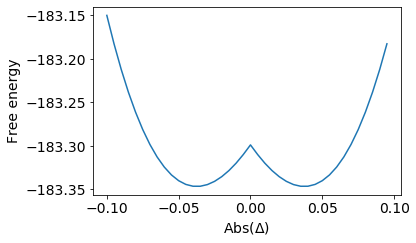

In [40]:
fig, ax = plt.subplots()

ax.plot(Deltas, Inbuilt)
ax.set_xlabel("Abs($\\Delta$)")
ax.set_ylabel("Free energy")

Convergence took 28 iterations
Convergence took 29 iterations


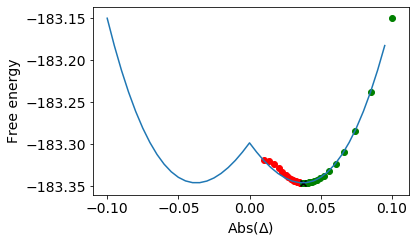

In [41]:
fig, ax = plt.subplots()

Model.Delta = 0.01*np.ones(Model.NN)
Model.iterate()
testDeltaF1 = Model.testDeltaF

Model.Delta = 0.1*np.ones(Model.NN)
Model.iterate()
testDeltaF2 = Model.testDeltaF

FinalDeltaF = np.array([Model.Delta[0].real,Model.get_free_energy()])

ax.plot(Deltas, Inbuilt)
ax.set_xlabel("Abs($\\Delta$)")
ax.set_ylabel("Free energy")

for DeltaF in testDeltaF1:
    ax.scatter(*DeltaF, color = "red")
for DeltaF in testDeltaF2:
    ax.scatter(*DeltaF, color = "green")
    
ax.scatter(*FinalDeltaF, marker = "x", color = "k")

## Currents

In [82]:
Ts = np.linspace(0, 0.6, 30)
betas = ['inf'] + list(1/Ts[1:])

n = 10
phi = 0
v = -2.25
Models = []
for beta in betas:
#     if beta is float and beta < betas[12]:
#         v = 0
    chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0,PBC = True, phase = 0)
    Model = simple_ring(chain, beta = beta)

    ls = np.ones(Model.NN)
    A = ((0*2 + 0.5)*np.pi)/(Model.NN)
    Model.add_hopping_phases_distributed(ls, A)

    Model.iterate()
    Models.append(Model)

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 20 iterations
Convergence took 20 iterations
Convergence took 22 iterations
Convergence took 24 iterations
Convergence took 28 iterations
Convergence took 34 iterations
Convergence took 44 iterations
Convergence took 67 iterations
Convergence took 194 iterations
Convergence took 769 iterations
Convergence took 502 iterations
Convergence took 373 iterations
Convergence took 291 iterations
Convergence took 236 iterations
Convergence took 200 iterations
Convergence took 174 iterations
Convergence took 154 iterations
Convergence took 139 iterations
Convergence took 127 iterations
Convergence took 117 iterations
Convergence took 109 iterations
Convergence took 101 iterations
Convergence took 95 iterations
Convergence took 90 iterations
Convergence took 86 iterations


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$\\Delta$')

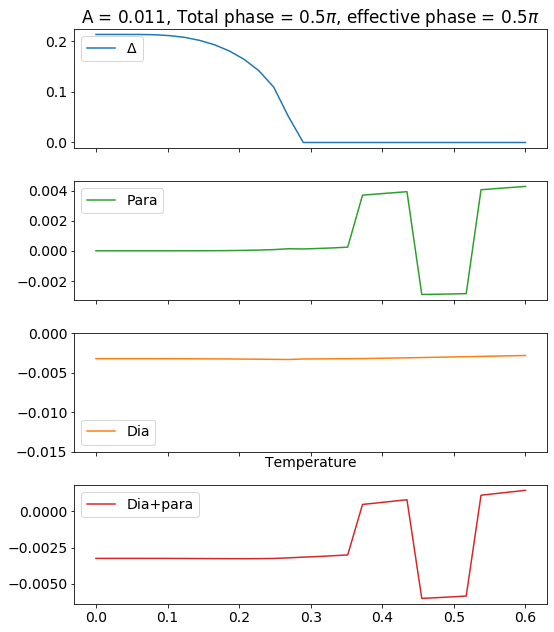

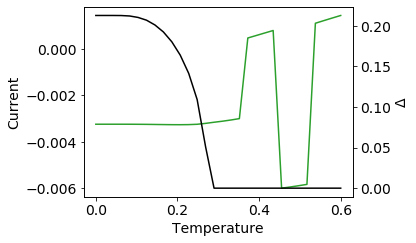

In [83]:
fig, axes = plt.subplots(4, sharex = True, figsize = (8,9))
ax1, ax2, ax3, ax4 = axes
ax1.plot(Ts, [np.average(Model.Delta.real) for Model in Models],"C0", label = "$\\Delta$")

ax2.plot(Ts, [np.sum(Model.get_current_para2()).real for Model in Models],"C2", label ="Para")


ax3.plot(Ts, [np.sum(Model.get_current_dia2()) for Model in Models], "C1", label = "Dia")
ax3.set_ylim([-0.015,0])


ax4.plot(Ts, [np.sum(Model.get_current_dia2()) + np.sum(Model.get_current_para2()) for Model in Models], "C3", label = "Dia+para")


ax1.legend(loc = "upper left")
ax2.legend()
ax3.legend()
ax4.legend()

ax3.set_xlabel("Temperature")

totalPhase = (Model.NN*A)

ax1.set_title("A = {:.2g}, Total phase = {:.1f}$\\pi$, effective phase = {:.1f}$\\pi$".format(A, totalPhase/np.pi, (totalPhase%(2*np.pi))/np.pi))

# plt.savefig("temp2pi.png")

fig, ax = plt.subplots()

# ax.plot(Ts, [np.sum(Model.get_current_dia2()) for Model in Models], "C0", label = "Dia")
# ax.plot(Ts, [np.sum(Model.get_current_para2()) for Model in Models], "C1", label = "Para")
ax.plot(Ts, [np.sum(Model.get_current_para2() + Model.get_current_dia2()) for Model in Models], "C2", label = "Total")

# ax.legend()

ax.set_xlabel("Temperature")

ax1 = ax.twinx()
ax1.plot(Ts, [np.average(Model.Delta.real) for Model in Models], "k")

ax.set_ylabel("Current")
ax1.set_ylabel("$\\Delta$")



# Fibonacci case

In [55]:
Ts = np.linspace(0, 0.6, 20)
betas = ['inf'] + list(1/Ts[1:])

n = 7
phi = 0
v = -2.25
Models = []
for beta in betas:
#     if beta is float and beta < betas[12]:
#         v = 0
    chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0.001,PBC = True, phase = 0)
    Model = simple_ring(chain, beta = beta)

    ls = np.ones(Model.NN)
    A = ((0*2 + 0.5)*np.pi)/(Model.NN)
    Model.add_hopping_phases_collected(ls, A)

    Model.iterate()
    Models.append(Model)

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 21 iterations
Convergence took 23 iterations
Convergence took 29 iterations
Convergence took 40 iterations
Convergence took 76 iterations
Convergence took 896 iterations
Convergence took 447 iterations
Convergence took 297 iterations
Convergence took 222 iterations
Convergence took 177 iterations
Convergence took 148 iterations
Convergence took 128 iterations
Convergence took 113 iterations
Convergence took 102 iterations
Convergence took 93 iterations
Convergence took 86 iterations


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'A = 0.046, Total phase = 0.5$\\pi$, effective phase = 0.5$\\pi$')

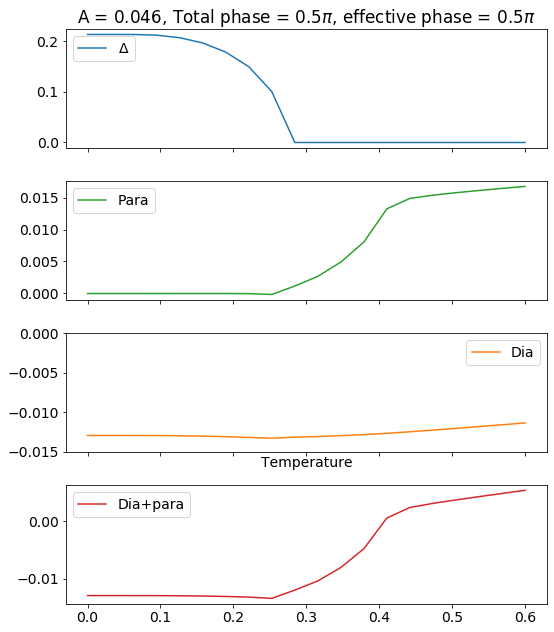

In [56]:
fig, axes = plt.subplots(4, sharex = True, figsize = (8,9))
ax1, ax2, ax3, ax4 = axes
ax1.plot(Ts, [np.average(Model.Delta.real) for Model in Models],"C0", label = "$\\Delta$")

ax2.plot(Ts, [np.sum(Model.get_current_para2()).real for Model in Models],"C2", label ="Para")


ax3.plot(Ts, [np.sum(Model.get_current_dia2()) for Model in Models], "C1", label = "Dia")
ax3.set_ylim([-0.015,0])


ax4.plot(Ts, [np.sum(Model.get_current_dia2()) + np.sum(Model.get_current_para2()) for Model in Models], "C3", label = "Dia+para")


ax1.legend(loc = "upper left")
ax2.legend()
ax3.legend()
ax4.legend()

ax3.set_xlabel("Temperature")

totalPhase = (Model.NN*A)

ax1.set_title("A = {:.2g}, Total phase = {:.1f}$\\pi$, effective phase = {:.1f}$\\pi$".format(A, totalPhase/np.pi, (totalPhase%(2*np.pi))/np.pi))

# plt.savefig("temp2pi.png")

## Current density profile

### 0T case

Convergence took 19 iterations


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$\\Delta$')

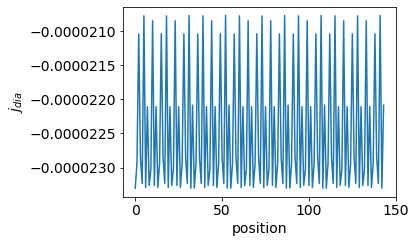

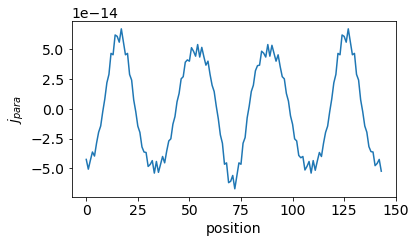

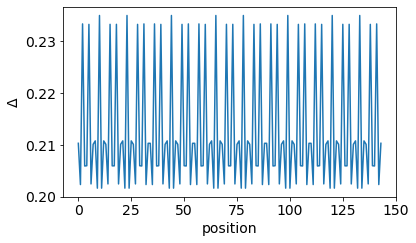

In [108]:
n = 10
phi = 0
v = -2.25
Models = []
beta = 'inf'

chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0.05,PBC = True, phase = 0)
Model = simple_ring(chain, beta = beta)

ls = np.ones(Model.NN)
A = ((0*2 + 0.5)*np.pi)/(Model.NN)
Model.add_hopping_phases_distributed(ls, A)

Model.iterate()
Models.append(Model)

fig, ax = plt.subplots()

ax.plot(np.sum(Model.get_current_dia2(), axis = 0))
ax.set_xlabel("position")
ax.set_ylabel("$j_{dia}$")

fig, ax = plt.subplots()

ax.plot(np.sum(Model.get_current_para2(), axis = 0))
ax.set_xlabel("position")
ax.set_ylabel("$j_{para}$")

fig, ax = plt.subplots()

ax.plot(Model.Delta.real)
ax.set_xlabel("position")
ax.set_ylabel("$\\Delta$")


### T~<T_c

Convergence took 21 iterations


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$\\Delta$')

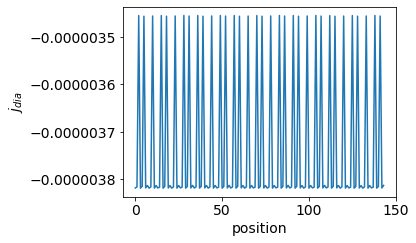

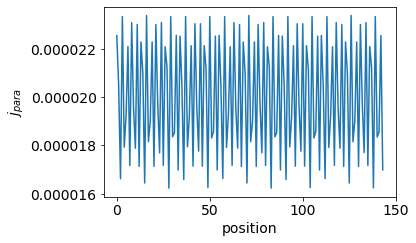

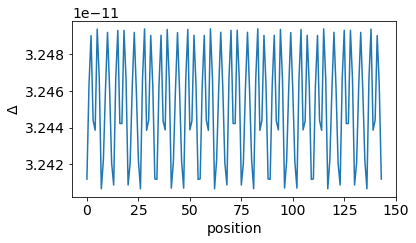

In [105]:
n = 10
phi = 0
v = -2.25
Models = []
beta = 0.2

chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0.05,PBC = True, phase = 0)
Model = simple_ring(chain, beta = beta)

ls = np.ones(Model.NN)
A = ((0*2 + 0.5)*np.pi)/(Model.NN)
Model.add_hopping_phases_distributed(ls, A)

Model.iterate()
Models.append(Model)

fig, ax = plt.subplots()

ax.plot(np.sum(Model.get_current_dia2(), axis = 0))
ax.set_xlabel("position")
ax.set_ylabel("$j_{dia}$")

fig, ax = plt.subplots()

ax.plot(np.sum(Model.get_current_para2(), axis = 0))
ax.set_xlabel("position")
ax.set_ylabel("$j_{para}$")

fig, ax = plt.subplots()

ax.plot(Model.Delta.real)
ax.set_xlabel("position")
ax.set_ylabel("$\\Delta$")

### T>T_c

Convergence took 27 iterations


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$\\Delta$')

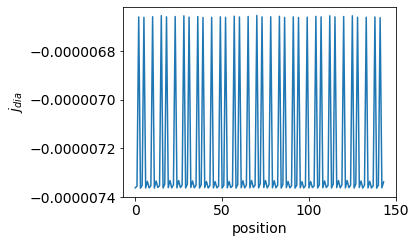

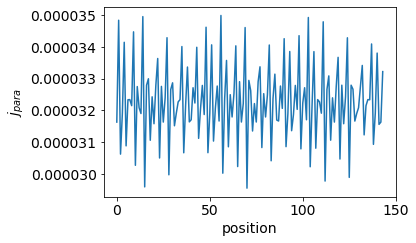

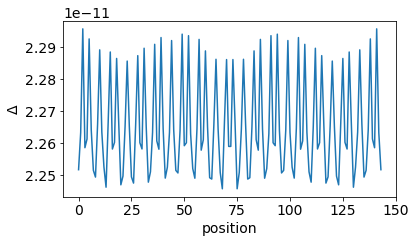

In [106]:
n = 10
phi = 0
v = -2.25
Models = []
beta = 0.4

chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0.05,PBC = True, phase = 0)
Model = simple_ring(chain, beta = beta)

ls = np.ones(Model.NN)
A = ((0*2 + 0.5)*np.pi)/(Model.NN)
Model.add_hopping_phases_distributed(ls, A)

Model.iterate()
Models.append(Model)

fig, ax = plt.subplots()

ax.plot(np.sum(Model.get_current_dia2(), axis = 0))
ax.set_xlabel("position")
ax.set_ylabel("$j_{dia}$")

fig, ax = plt.subplots()

ax.plot(np.sum(Model.get_current_para2(), axis = 0))
ax.set_xlabel("position")
ax.set_ylabel("$j_{para}$")

fig, ax = plt.subplots()

ax.plot(Model.Delta.real)
ax.set_xlabel("position")
ax.set_ylabel("$\\Delta$")

## Currents via Gibbs potential

0it [00:00, ?it/s]

Convergence took 19 iterations
Convergence took 19 iterations


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
1it [00:01,  1.35s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


2it [00:03,  1.51s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


3it [00:05,  1.70s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


4it [00:07,  1.77s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


5it [00:09,  1.83s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


6it [00:11,  1.94s/it]

Convergence took 19 iterations
Convergence took 20 iterations
Convergence took 20 iterations


7it [00:13,  1.98s/it]

Convergence took 20 iterations
Convergence took 21 iterations
Convergence took 21 iterations


8it [00:15,  1.98s/it]

Convergence took 21 iterations
Convergence took 23 iterations
Convergence took 23 iterations


9it [00:17,  2.00s/it]

Convergence took 23 iterations
Convergence took 25 iterations
Convergence took 25 iterations


10it [00:19,  2.08s/it]

Convergence took 25 iterations
Convergence took 28 iterations
Convergence took 28 iterations


11it [00:22,  2.25s/it]

Convergence took 28 iterations
Convergence took 33 iterations
Convergence took 33 iterations


12it [00:26,  2.71s/it]

Convergence took 33 iterations
Convergence took 40 iterations
Convergence took 40 iterations


13it [00:29,  3.00s/it]

Convergence took 40 iterations
Convergence took 54 iterations
Convergence took 54 iterations


14it [00:34,  3.54s/it]

Convergence took 54 iterations
Convergence took 92 iterations
Convergence took 92 iterations


15it [00:42,  4.93s/it]

Convergence took 92 iterations
Convergence took 1156 iterations
Convergence took 1152 iterations


16it [02:26, 34.51s/it]

Convergence took 1151 iterations
Convergence took 682 iterations
Convergence took 680 iterations


17it [03:25, 41.90s/it]

Convergence took 683 iterations
Convergence took 481 iterations
Convergence took 482 iterations


18it [04:07, 41.96s/it]

Convergence took 479 iterations
Convergence took 368 iterations
Convergence took 368 iterations


19it [04:39, 39.00s/it]

Convergence took 369 iterations
Convergence took 296 iterations
Convergence took 297 iterations


20it [05:05, 15.29s/it]
0it [00:00, ?it/s]

Convergence took 297 iterations
Convergence took 19 iterations
Convergence took 19 iterations


1it [00:01,  1.97s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


2it [00:04,  2.10s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


3it [00:06,  2.18s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


4it [00:09,  2.25s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


5it [00:11,  2.30s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


6it [00:13,  2.32s/it]

Convergence took 19 iterations
Convergence took 20 iterations
Convergence took 20 iterations


7it [00:16,  2.37s/it]

Convergence took 20 iterations
Convergence took 21 iterations
Convergence took 21 iterations


8it [00:19,  2.45s/it]

Convergence took 21 iterations
Convergence took 23 iterations
Convergence took 23 iterations


9it [00:21,  2.57s/it]

Convergence took 23 iterations
Convergence took 25 iterations
Convergence took 25 iterations


10it [00:25,  2.73s/it]

Convergence took 25 iterations
Convergence took 28 iterations
Convergence took 28 iterations


11it [00:28,  2.97s/it]

Convergence took 28 iterations
Convergence took 33 iterations
Convergence took 33 iterations


12it [00:32,  3.29s/it]

Convergence took 33 iterations
Convergence took 40 iterations
Convergence took 40 iterations


13it [00:37,  3.77s/it]

Convergence took 40 iterations
Convergence took 54 iterations
Convergence took 54 iterations


14it [00:44,  4.61s/it]

Convergence took 54 iterations
Convergence took 92 iterations
Convergence took 92 iterations


15it [00:55,  6.56s/it]

Convergence took 92 iterations
Convergence took 1164 iterations
Convergence took 1176 iterations


16it [02:57, 41.16s/it]

Convergence took 1164 iterations
Convergence took 705 iterations
Convergence took 706 iterations


17it [04:17, 53.01s/it]

Convergence took 705 iterations
Convergence took 497 iterations
Convergence took 497 iterations


18it [05:18, 55.26s/it]

Convergence took 497 iterations
Convergence took 379 iterations
Convergence took 379 iterations


19it [06:10, 54.25s/it]

Convergence took 379 iterations
Convergence took 297 iterations
Convergence took 297 iterations


20it [06:50, 20.51s/it]
0it [00:00, ?it/s]

Convergence took 297 iterations
Convergence took 19 iterations
Convergence took 19 iterations


1it [00:01,  1.65s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


2it [00:04,  1.89s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


3it [00:06,  2.00s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


4it [00:08,  2.18s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


5it [00:11,  2.35s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


6it [00:13,  2.31s/it]

Convergence took 19 iterations
Convergence took 20 iterations
Convergence took 20 iterations


7it [00:15,  2.22s/it]

Convergence took 20 iterations
Convergence took 21 iterations
Convergence took 21 iterations


8it [00:17,  2.15s/it]

Convergence took 21 iterations
Convergence took 23 iterations
Convergence took 23 iterations


9it [00:20,  2.17s/it]

Convergence took 23 iterations
Convergence took 25 iterations
Convergence took 25 iterations


10it [00:23,  2.52s/it]

Convergence took 25 iterations
Convergence took 28 iterations
Convergence took 28 iterations


11it [00:26,  2.62s/it]

Convergence took 28 iterations
Convergence took 33 iterations
Convergence took 33 iterations


12it [00:29,  2.78s/it]

Convergence took 33 iterations
Convergence took 40 iterations
Convergence took 40 iterations


13it [00:34,  3.45s/it]

Convergence took 40 iterations
Convergence took 54 iterations
Convergence took 54 iterations


14it [00:40,  4.09s/it]

Convergence took 54 iterations
Convergence took 92 iterations
Convergence took 92 iterations


15it [00:49,  5.65s/it]

Convergence took 92 iterations
Convergence took 1153 iterations
Convergence took 1145 iterations


16it [02:45, 38.95s/it]

Convergence took 1142 iterations
Convergence took 701 iterations
Convergence took 695 iterations


17it [03:53, 47.45s/it]

Convergence took 696 iterations
Convergence took 496 iterations
Convergence took 493 iterations


18it [04:42, 47.98s/it]

Convergence took 494 iterations
Convergence took 376 iterations
Convergence took 376 iterations


19it [05:19, 44.77s/it]

Convergence took 376 iterations
Convergence took 297 iterations
Convergence took 297 iterations


20it [05:49, 17.48s/it]
0it [00:00, ?it/s]

Convergence took 297 iterations
Convergence took 19 iterations
Convergence took 19 iterations


1it [00:01,  1.59s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


2it [00:03,  1.75s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


3it [00:05,  1.85s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


4it [00:07,  1.91s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


5it [00:09,  1.96s/it]

Convergence took 19 iterations
Convergence took 19 iterations
Convergence took 19 iterations


6it [00:11,  1.97s/it]

Convergence took 19 iterations
Convergence took 20 iterations
Convergence took 20 iterations


7it [00:13,  1.99s/it]

Convergence took 20 iterations
Convergence took 21 iterations
Convergence took 21 iterations


8it [00:16,  2.04s/it]

Convergence took 21 iterations
Convergence took 23 iterations
Convergence took 23 iterations


9it [00:18,  2.10s/it]

Convergence took 23 iterations
Convergence took 25 iterations
Convergence took 25 iterations


10it [00:20,  2.21s/it]

Convergence took 25 iterations
Convergence took 28 iterations
Convergence took 28 iterations


11it [00:23,  2.39s/it]

Convergence took 28 iterations
Convergence took 33 iterations
Convergence took 33 iterations


12it [00:26,  2.63s/it]

Convergence took 33 iterations
Convergence took 40 iterations
Convergence took 40 iterations


13it [00:30,  3.09s/it]

Convergence took 40 iterations
Convergence took 54 iterations
Convergence took 54 iterations


14it [00:36,  3.73s/it]

Convergence took 54 iterations
Convergence took 92 iterations
Convergence took 92 iterations


15it [00:44,  5.03s/it]

Convergence took 92 iterations
Convergence took 1151 iterations
Convergence took 1152 iterations


16it [02:32, 35.95s/it]

Convergence took 1156 iterations
Convergence took 683 iterations
Convergence took 680 iterations


17it [03:39, 45.33s/it]

Convergence took 682 iterations
Convergence took 479 iterations
Convergence took 482 iterations


18it [04:26, 45.87s/it]

Convergence took 481 iterations
Convergence took 369 iterations
Convergence took 368 iterations


19it [05:02, 42.80s/it]

Convergence took 368 iterations
Convergence took 297 iterations
Convergence took 297 iterations


20it [05:31, 16.56s/it]

Convergence took 296 iterations



/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


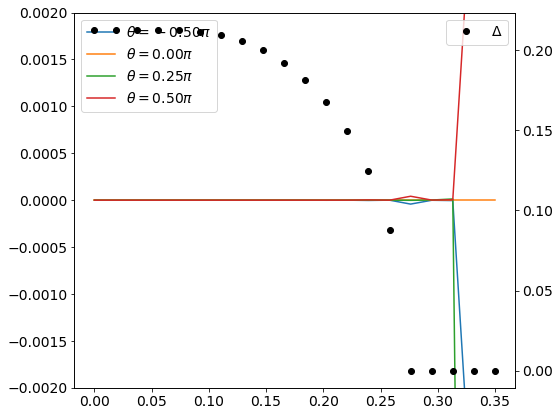

In [31]:
n = 10
v = -2.25
u = -v/2
w = 0.0

Ts = np.linspace(0, 0.35, 20)
betas = ['inf'] + list(1/Ts[1:])

phases = np.array([-np.pi/2,0, np.pi/4,np.pi/2])
dphase = np.pi/64

Deltas = []

Current = {}

for phase in phases:
    Current[phase] = []
    theta_list = np.array([phase - dphase, phase, phase+dphase])
    
    for T, beta in tqdm(zip(Ts,betas)):
        ev_list = []
        for theta in theta_list:
            chain = chainFC(n = n, v = v, u = u, w = w,PBC = True, phase = theta)
            Model = simple_ring(chain, beta = beta)
            Model.Delta = np.ones(Model.NN)
            Model.iterate()
            ev_list.append(Model.evals)
            
        dev = (ev_list[-1] - ev_list[0])/2
        current_contribution = np.tanh(ev_list[1]/(2*T))*dev/dphase
        
        Current[phase].append(np.sum(current_contribution))
        Deltas.append(Model.Delta[0])
        
fig, ax = plt.subplots(figsize = (8,6))

for phase in phases:
    ax.plot(Ts, Current[phase],label = "$\\theta = {:.2f} \\pi$".format(phase/np.pi))
ax1 = ax.twinx()
ax1.plot(Ts, Deltas[:len(Ts)], "ko",label = "$\\Delta$")
ax.set_ylim([-0.002,0.002])
ax.legend()
ax1.legend()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


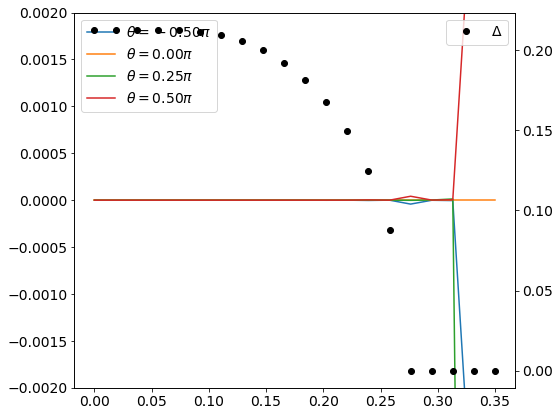

In [32]:
fig, ax = plt.subplots(figsize = (8,6))

for phase in phases:
    ax.plot(Ts, Current[phase],label = "$\\theta = {:.2f} \\pi$".format(phase/np.pi))
ax1 = ax.twinx()
ax1.plot(Ts, Deltas[:len(Ts)], "ko",label = "$\\Delta$")
ax.set_ylim([-0.002,0.002])
ax.legend()
ax1.legend()